# LandLab Learning

This notebook is for investigating and getting used to the LandLab Python package for hydrology modelling.

I will broadly follow the guide on https://landlab.readthedocs.io/en/latest/user_guide

In [1]:
import numpy as np
import landlab as ldlb
import matplotlib.pyplot as plt

## Set up a model grid

... and add an idealised quadratic elevation profile to it, mimicking a valley.

In [2]:
from landlab import RasterModelGrid

In [19]:
#set up 40x40 grid
mg = RasterModelGrid((102, 102), 5.)

#let's try to add an idealised elevation profile to this grid.
valley = np.zeros((102,102))

def valleyfunc(x, y):
    e = (x-51)**2 + y
    return e

for x in np.arange(0, 102, 1):
    for y in np.arange(0, 102, 1):
        valley[y][x] = valleyfunc(x,y)

mg.add_field("topographic__elevation", valley, at="node", units="m", copy=True, clobber=True) # The elevation field needs to have exactly 
                                                                                              # this name in order for components to be 
                                                                                              # able to work with it.

array([ 2601.,  2500.,  2401., ...,  2405.,  2502.,  2601.])

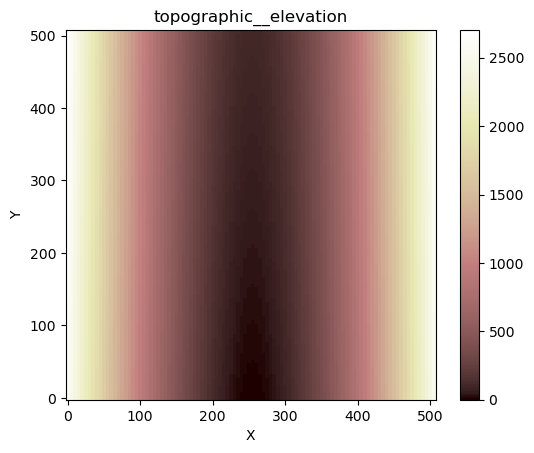

In [20]:
from landlab.plot.imshow import imshow_grid_at_node
#N.B. the Landlab user guide tells you to import the wrong component here

plt.figure('Elevations from the field')  # new fig, with a name
imshow_grid_at_node(mg, 'topographic__elevation') 
plt.show()

Note that the vegetation is set up at the 'cell' level, while the elevation is set at the 'node' level. Nodes are the cell centres (meaning there is a well-defined way to calculate gradients between values at nodes of neighbouring cells), while 'cell' data lives uniformly across the entire volume of the cell. On a grid, there are fewer cells than nodes: the boundary rows do not count as cells.

For us, this probably means we want our Landlab grid to be two nodes larger in $x$ and $y$ than our NetLogo grid: This means they have the same number of cells, but the Landlab grid also has an additional rim of nodes around the outside that we can set boundary conditions on.

I now want to start trying to reproduce some of what Zhou et al. (2013) did - this means trying to match the Landlab components they added to the description in the paper and accompanying Jupyter notebook.

First, we import the required modules:
 - Vegetation: Model plant dynamics using multiple representative plant species. Landlab component that simulates net primary productivity, biomass and leaf area index at each cell based on inputs of root-zone average soil moisture. https://landlab.readthedocs.io/en/latest/reference/components/vegetation_dynamics.html
 - SoilMoisture: Compute the decay of soil moisture saturation at storm-interstorm time period. Landlab component that simulates root-zone average soil moisture at each cell using inputs of potential evapotranspiration, live leaf area index, and vegetation cover. https://landlab.readthedocs.io/en/latest/reference/components/soil_moisture.html
 - Radiation: Calculate solar radiation on topography given latitude, date, and time. Landlab component that computes 1D and 2D total incident shortwave radiation. This code also computes relative incidence shortwave radiation compared to a flat surface. https://landlab.readthedocs.io/en/latest/reference/components/radiation.html
 - PotentialEvapotranspiration: Compute potential evapotranspiration. Component calculates spatially distributed potential evapotranspiration based on input radiation factor (spatial distribution of incoming radiation) using chosen method such as constant or Priestley Taylor. https://landlab.readthedocs.io/en/latest/reference/components/pet.html#landlab.components.pet.potential_evapotranspiration_field.PotentialEvapotranspiration
 - PrecipitationDistribution: Generate random sequence of precipitation events. This component can generate a random storm duration, interstorm duration, precipitation intensity or storm depth from a Poisson distribution when given a mean value. https://landlab.readthedocs.io/en/latest/reference/components/uniform_precip.html . I don't know if we want to use this component for our model - it seems most suited to climates where precipitation occurs mostly in intense storms that are few and far between - i.e., dry savanna. This is likely not the case for the area we are trying to model, where I expect we have rainfall quite frequently outside the Canicula dry period.
 

In [21]:
from landlab.components import Vegetation
from landlab.components import SoilMoisture
from landlab.components import Radiation
from landlab.components import PotentialEvapotranspiration
from landlab.components import PrecipitationDistribution

Our mission statement: Receive land cover input, give soil moisture/biomass growth output

For our initial toy model, let's use what's already there and make use of the PrecipitationDistribution component to generate our rainfall time series, and make our time step based on that.

First, we make a configuration file to specify a few key variables.

In [22]:
config = {
    # assume Canicula starts on 1st of July and lasts for 40 days
    'canicula_start':182,
    'canicula_end':223, 
    # I pulled the following out of my behind, need to check with local climatology if this is sensible
    'mean_interstorm_wet':5,
    'mean_storm_wet':2,
    'mean_interstorm_dry':20,
    'mean_storm_dry':2
}

Calculate number of time steps based on rainfall likelihood and duration as well as desired length of simulation in years

In [23]:
n_years = 50  # Approx number of years for model to run
# Calculate approximate number of storms per year
fraction_dry = (223 - 182) / 365.0 #assume Canicula starts on 1st of July and lasts for 40 days
fraction_wet = 1 - fraction_dry
no_of_storms_wet = (
    365 * (fraction_wet) / (config["mean_interstorm_wet"] + config["mean_storm_wet"])
)
no_of_storms_dry = (
    365 * (fraction_dry) / (config["mean_interstorm_dry"] + config["mean_storm_dry"])
)
# calculate total number of storms
n = int(n_years * (no_of_storms_wet + no_of_storms_dry))

In [24]:
'''Set some helper variables that we will need in the main model loop'''
# Represent current time in years (N.B. this is a float, so 0.5 would be mid-June of the first model year)
current_time = 0  # Start from first day of Jan

# declaring few variables that will be used in the storm loop
time_check = 0.0  # Buffer to store current_time at previous storm
yrs = 0  # Keep track of number of years passed
WS = 0.0  # Buffer for Water Stress
Tg = 270  # Growing season in days


In [25]:
#initialise timeseries 

P = np.zeros(365) #empty array for rainfall
Tr = np.zeros(365) #empty array for rainfall event durations
Tb = np.zeros(365) #empty array for dry spell durations

Time = np.zeros(n) #empty array to record timestamps at which calculations are made in main loop (non-uniform time step length)

Now that we have those things out of the way, we generate precipitation events based on the parameters set earlier:

In [26]:
'''
Commenting this out because it assigns things to the grid. Current implementation needs just an array though.
# N.B. to make this (grid-based implementation of precipitation) run, find the 'generate_uniform_precip.py' file in your 
# LandLab distribution, and add a 'clobber=True' statement to the self.grid.add_field() call in L185 
# (this becomes more obvious if you run the cell and look at the error message).
PD_D = PrecipitationDistribution(mg, mean_storm_duration=config['mean_storm_dry'], mean_interstorm_duration=config['mean_interstorm_dry'],
                                 mean_storm_depth=0.5, total_t=40)

PD_W = PrecipitationDistribution(mg, mean_storm_duration=config['mean_storm_wet'], mean_interstorm_duration=config['mean_interstorm_wet'],
                                 mean_storm_depth=0.5, total_t=325)

if we choose this way of assigning precipitation, there should then be a `rainfall__flux` field on our grid, although I am not sure 
how to access it as it is added to the entire grid rather than individual nodes.
'''

PD_D = PrecipitationDistribution(mean_storm_duration=config['mean_storm_dry'], mean_interstorm_duration=config['mean_interstorm_dry'],
                                 mean_storm_depth=0.5, total_t=40)

PD_W = PrecipitationDistribution(mean_storm_duration=config['mean_storm_wet'], mean_interstorm_duration=config['mean_interstorm_wet'],
                                 mean_storm_depth=0.5, total_t=325)


Our model then also needs an input of radiation, which feeds into the Potential Evapotranspiration calculation. The Radiation component by default assumes a `latitude` of 34 degrees, an `albedo` of 0.2 (might want to alter this depending on surface cover) and a `cloudiness` of 0.2. By default the time of day (`hour`) is set to 12, i.e. midday.
Apart from those optional inputs with default values, we have to pass in a `current_time` in years (float), from which it calculates the Julian day and hence the solar Zenith angle to come up with the season-appropriate amount of radiation. We initialise this now and then update with time of year when running the actual model loop.


In [27]:
rad = Radiation(mg, current_time=current_time)

Having set this, we can now initialise the Potential Evapotranspiration field (the amount of water evaporation that would occur if there was unlimited water availability). Upon reading the documentation for this, it seems like this has a calculation of radiation built in, taking a lot of the same inputs - so we might get away without having to use the Radiation component! However, it does need an input of radiation with respect to a flat surface, which is something the Radiation component calculates, so we should probably leave it in if we're to include topography (i.e., sloping fields).

We can (and probably should) pass an average, minimum and maximum temperature of the day (`Tavg`, `Tmin`, `Tmax`) into this when using `method = Priestley Taylor`. The Priestley-Taylor equations are a simplified version of the Penman-Monteith Equations for Evapotranspiration - they remove the need for wind observations, replacing aerodynamic effects with an empirical constant.
It is also possible to set the method to `cosine` - reading the paper, I think this is a fit of the Penman-Monteith equations to historical weather data from the study area (removing the need for any temperature input, meaning you only have to supply rainfall and slope) and therefore not suitable for us as we are looking at a different climate.

In [29]:
PET = PotentialEvapotranspiration(mg, current_time=current_time)

In the model paper, they only use PET directly when calculating the (soil moisture-limited) evaporation from bare soil. When plants are present, actual evaporation is further moderated by leaf area index and canopy interception capacity (Equation 5). We need to figure out how and where these further calculations are implemented in landlab.

Moderation of evaporation by soil moisture in the presence of plants is also dependent on soil saturation degree at hygroscopic capacity, wilting point, and incipient stomata closure as well as actual soil moisture.

Soil moisture in the model is calculated from rain influx minus leakage from root zone minus surface runoff. Surface runoff and percolation depend on ground cover, soil saturation and soil properties. The soil infiltration capacity is moderated by the presence of plants (model equations 1 to 4).

(side note: generally (from looking at the equations and their descriptions), I get the impression that in this model, the presence of vegetation increases evaporation and decreases the capacity of the soil to absorb new water. This seems contrary to the behaviour we expect. We might need to do some fudging to make presence of plants, e.g., limit the leakage of water from the root zone - but to do this fudging sensibly, we need to read more of the literature on ecohydrology). We could make this capacity of the soil to retain moisture depend on both live and dead root biomass that can hopefully be output from the vegetation dynamics component (equation 11).

Mean soil moisture (I am not too sure how long they average for!) along with wilting point and incipient stomata closure can then be used to calculate water stress (Equation 15).

Finally, we can then also define plant productivity. 

In [15]:
# # Run storm Loop
for i in range(0, n):
    # Update objects

    # Calculate Day of Year (DOY)
    Julian = int(np.floor((current_time - np.floor(current_time)) * 365.0))

    # Generate seasonal storms
    # for Dry season
    if Julian < config['canicula_end'] or Julian > config['canicula_start']: 
        PD_D.update()
        P[i] = PD_D.storm_depth
        Tr[i] = PD_D.storm_duration
        Tb[i] = PD_D.interstorm_duration
    # Wet Season 
    else:
        PD_W.update()
        P[i] = PD_W.storm_depth
        Tr[i] = PD_W.storm_duration
        Tb[i] = PD_W.interstorm_duration

    # calculate radiation for each field based on day of the year
    #rad.current_time = current_time
    #rad.update()

    # Spatially distribute PET and its 30-day-mean (analogous to degree day)
    #mg["cell"]["surface__potential_evapotranspiration_rate"] = PET_[Julian]
    #mg["cell"]["surface__potential_evapotranspiration_30day_mean"] = EP30[Julian]

    # calculate PET for each field based on day of the year
    PET.current_time = current_time
    PET.update()

    # Assign spatial rainfall data
    mg["cell"]["rainfall__daily_depth"] = P[i] * np.ones(mg.number_of_cells)

    # Update soil moisture component
    current_time = SM.update(current_time, Tr=Tr[i], Tb=Tb[i])

    # Decide whether its growing season or not
    if Julian != 364:
        if EP30[Julian + 1, 0] > EP30[Julian, 0]:
            PET_threshold = 1
            # 1 corresponds to ETThresholdup (begin growing season)
        else:
            PET_threshold = 0
            # 0 corresponds to ETThresholddown (end growing season)

    # Update vegetation component
    VEG.update(PETThreshold_switch=PET_threshold, Tb=Tb[i], Tr=Tr[i])

    # Update yearly cumulative water stress data
    WS += (grid["cell"]["vegetation__water_stress"]) * Tb[i] / 24.0

    # Record time (optional)
    Time[i] = current_time

    # Update spatial PFTs with Cellular Automata rules
    if (current_time - time_check) >= 1.0:
        if yrs % 100 == 0:
            print(f"Elapsed time = {yrs} years")
        VegType[yrs] = grid1["cell"]["vegetation__plant_functional_type"]
        WS_ = np.choose(VegType[yrs], WS)
        grid1["cell"]["vegetation__cumulative_water_stress"] = WS_ / Tg
        vegca.update()
        time_check = current_time
        WS = 0
        yrs += 1

VegType[yrs] = grid1["cell"]["vegetation__plant_functional_type"]

NameError: name 'PET_' is not defined